In [1]:
import pickle
import sys
import os
sys.path.append("/".join(os.getcwd().split("/")[:-2]))
import common
import torch
from tqdm import tqdm

checkpoint_path = "/local/huzaifa/CoreInfer/models/opt-6.7b"
model_name = "opt-6.7b"
num_neurons = common.MODEL_INFO[model_name]["num_neurons"]
model, tokenizer, num_layers = common.load_model(model_name, 5, 27, checkpoint_path, "cpu", None)

/local/huzaifa/jupytervenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


Done. Loaded model in 1.33 seconds.



In [32]:
def get_sparsity_levels_params(model_name, num_layers, activations, max_iterations, number_of_requested_values, sparsity_goal, allowed_tolerance, start_num, end_num):

    counter = 0
    possible_values = []
    possible_sparsity_levels = []

    possible_weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    possible_thresholds = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]


    calculated_sparsity_levels = []

    while counter < max_iterations and len(possible_values) < number_of_requested_values:
        i = 0
        for sum_weight in possible_weights:
            count_weight = 1 - sum_weight
            skip_thresholds = False
            for threshold in possible_thresholds:
                
                if skip_thresholds:
                    continue
                
                top_k = 100
                params = [sum_weight, count_weight, threshold, top_k]
                
                # Get sparsity levels
                if counter == 0:
                    sparsity_levels = common.get_sparsity_levels(model_name, num_layers, params[0], params[1], params[2], params[3], activations)
                    calculated_sparsity_levels.append(sparsity_levels)
                else:
                    sparsity_levels = calculated_sparsity_levels[i]
                
                # Get the avg sparsity
                cut_sparsity_levels = sparsity_levels[start_num+1:end_num]
                avg_sparsity = sum(cut_sparsity_levels) / len(cut_sparsity_levels)
                  
                print(f"{i}. Actual sparsity: {avg_sparsity} | Params: {(params[0], params[1], params[2], params[3])}")
                
                if avg_sparsity < sparsity_goal - allowed_tolerance:
                    skip_thresholds = True
                                    
                if abs(sparsity_goal - avg_sparsity) <= allowed_tolerance:
                    print(f"Found a possible params: {params}")
                    possible_values.append(params)
                    possible_sparsity_levels.append(sparsity_levels)
                
                if counter > max_iterations or len(possible_values) >= number_of_requested_values:
                    break
                
                i += 1
                
            if counter > max_iterations or len(possible_values) >= number_of_requested_values:
                break
                
            
        counter += 1
        
    return possible_values, possible_sparsity_levels

In [74]:
def save_levels(levels, dataset_name):
    levels_path = f"/local/huzaifa/CoreInfer/ignore/opt-6.7b_sparsity_levels_files/sparsity_levels/{model_name}/{dataset_name}/"
    os.makedirs(os.path.dirname(levels_path), exist_ok=True)
    for i,l in enumerate(levels):
        with open(f"{levels_path}sparsity_levels{i}.pkl", "wb") as f:
            pickle.dump(l, f)

In [68]:
def draw_levels(levels, dataset_name):
    import matplotlib.pyplot as plt
    import numpy as np

    # Create the plot
    plt.figure(figsize=(10, 6))
    # Create a colormap with distinct colors using HSV color space
    num_configs = len(levels)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_configs))

    # Create different line styles to alternate between
    line_styles = ['-', '--', '-.', ':']
    line_widths = [1, 1.5, 2]

    # Create the plot with different combinations of colors, styles and widths
    for i in range(num_configs):
        style_idx = i % len(line_styles)
        width_idx = (i // len(line_styles)) % len(line_widths)
        
        label = f'Sparsity_levels{i}'
        
        plt.plot(list(range(6, 27)), 
                levels[i][6:27],
                linestyle=line_styles[style_idx],
                color=colors[i],
                linewidth=line_widths[width_idx],
                label=label)

    # Add labels and title
    plt.xlabel('Layer Number')
    plt.xticks(range(6, 27, 1))
    plt.ylabel('Sparsity Level')
    plt.title(f'{dataset_name} Sparsity Levels')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=8)


    # Save the figure
    plt.tight_layout()
    plt.show()

## TruthfulQA

In [5]:
with open("/local/huzaifa/CoreInfer/ignore/activations/truthfulQA-opt-activations.pkl", "rb") as f:
    truthful_qa_activations = pickle.load(f)

In [33]:
truthful_qa_possible_params, truthful_qa_sparsity_levels = get_sparsity_levels_params(model_name, num_layers, truthful_qa_activations, 1, 1000, 0.26, 0.01, 5, 27)

0. Actual sparsity: 0.3042857142857143 | Params: (0.1, 0.9, 0.01, 100)
1. Actual sparsity: 0.30380952380952386 | Params: (0.1, 0.9, 0.015, 100)
2. Actual sparsity: 0.3019047619047619 | Params: (0.1, 0.9, 0.02, 100)
3. Actual sparsity: 0.29666666666666663 | Params: (0.1, 0.9, 0.025, 100)
4. Actual sparsity: 0.2795238095238095 | Params: (0.1, 0.9, 0.03, 100)
5. Actual sparsity: 0.25523809523809526 | Params: (0.1, 0.9, 0.035, 100)
Found a possible params: [0.1, 0.9, 0.035, 100]
6. Actual sparsity: 0.23 | Params: (0.1, 0.9, 0.04, 100)
7. Actual sparsity: 0.3042857142857143 | Params: (0.2, 0.8, 0.01, 100)
8. Actual sparsity: 0.30380952380952386 | Params: (0.2, 0.8, 0.015, 100)
9. Actual sparsity: 0.3019047619047619 | Params: (0.2, 0.8, 0.02, 100)
10. Actual sparsity: 0.2923809523809524 | Params: (0.2, 0.8, 0.025, 100)
11. Actual sparsity: 0.27476190476190476 | Params: (0.2, 0.8, 0.03, 100)
12. Actual sparsity: 0.25047619047619046 | Params: (0.2, 0.8, 0.035, 100)
Found a possible params: [0.

In [75]:
save_levels(truthful_qa_sparsity_levels, "truthfulqa_gen")

## BertaQA

In [35]:
from datasets import load_dataset
import utils

berta_qa_dataset = load_dataset("HiTZ/BertaQA", "en")
berta_qa_precessed_data = utils.process_data(berta_qa_dataset, "bertaqa_en")[:500]
berta_qa_activations = common.collect_activations(model_name, berta_qa_precessed_data, tokenizer, "cpu", model)

In [36]:
with open("/local/huzaifa/CoreInfer/ignore/activations/berta_qa_opt-6.7b_activations.pkl", "wb") as f:
    pickle.dump(berta_qa_activations, f)

In [41]:
berta_qa_possible_params, berta_qa_sparsity_levels = get_sparsity_levels_params(model_name, num_layers, berta_qa_activations, 1, 1000, 0.32, 0.01, 5, 27)

0. Actual sparsity: 0.36904761904761907 | Params: (0.1, 0.9, 0.01, 100)
1. Actual sparsity: 0.3647619047619048 | Params: (0.1, 0.9, 0.015, 100)
2. Actual sparsity: 0.3414285714285714 | Params: (0.1, 0.9, 0.02, 100)
3. Actual sparsity: 0.3004761904761905 | Params: (0.1, 0.9, 0.025, 100)
4. Actual sparsity: 0.3685714285714286 | Params: (0.2, 0.8, 0.01, 100)
5. Actual sparsity: 0.3633333333333334 | Params: (0.2, 0.8, 0.015, 100)
6. Actual sparsity: 0.3371428571428571 | Params: (0.2, 0.8, 0.02, 100)
7. Actual sparsity: 0.2980952380952381 | Params: (0.2, 0.8, 0.025, 100)
8. Actual sparsity: 0.3685714285714286 | Params: (0.3, 0.7, 0.01, 100)
9. Actual sparsity: 0.35952380952380947 | Params: (0.3, 0.7, 0.015, 100)
10. Actual sparsity: 0.33 | Params: (0.3, 0.7, 0.02, 100)
11. Actual sparsity: 0.2942857142857143 | Params: (0.3, 0.7, 0.025, 100)
12. Actual sparsity: 0.3676190476190476 | Params: (0.4, 0.6, 0.01, 100)
13. Actual sparsity: 0.35238095238095246 | Params: (0.4, 0.6, 0.015, 100)
14. Ac

In [76]:
save_levels(berta_qa_sparsity_levels, "bertaqa_en")

## SQUADV2

In [43]:
from datasets import load_dataset
import utils

squadv2_dataset = load_dataset("rajpurkar/squad_v2")
squadv2_precessed_data = utils.process_data(squadv2_dataset, "squadv2")[:500]
squadv2_activations = common.collect_activations(model_name, squadv2_precessed_data, tokenizer, "cpu", model)

In [44]:
with open("/local/huzaifa/CoreInfer/ignore/activations/squadv2_opt-6.7b_activations.pkl", "wb") as f:
    pickle.dump(squadv2_activations, f)

In [45]:
squadv2_possible_params, squadv2_sparsity_levels = get_sparsity_levels_params(model_name, num_layers, squadv2_activations, 1, 1000, 0.4, 0.01, 5, 27)

0. Actual sparsity: 0.4495238095238096 | Params: (0.1, 0.9, 0.01, 100)
1. Actual sparsity: 0.3804761904761904 | Params: (0.1, 0.9, 0.015, 100)
2. Actual sparsity: 0.4552380952380953 | Params: (0.2, 0.8, 0.01, 100)
3. Actual sparsity: 0.3904761904761904 | Params: (0.2, 0.8, 0.015, 100)
Found a possible params: [0.2, 0.8, 0.015, 100]
4. Actual sparsity: 0.3442857142857143 | Params: (0.2, 0.8, 0.02, 100)
5. Actual sparsity: 0.4561904761904761 | Params: (0.3, 0.7, 0.01, 100)
6. Actual sparsity: 0.3976190476190476 | Params: (0.3, 0.7, 0.015, 100)
Found a possible params: [0.3, 0.7, 0.015, 100]
7. Actual sparsity: 0.35285714285714287 | Params: (0.3, 0.7, 0.02, 100)
8. Actual sparsity: 0.45666666666666667 | Params: (0.4, 0.6, 0.01, 100)
9. Actual sparsity: 0.40238095238095245 | Params: (0.4, 0.6, 0.015, 100)
Found a possible params: [0.4, 0.6, 0.015, 100]
10. Actual sparsity: 0.3595238095238096 | Params: (0.4, 0.6, 0.02, 100)
11. Actual sparsity: 0.45523809523809516 | Params: (0.5, 0.5, 0.01,

In [77]:
save_levels(squadv2_sparsity_levels, "squadv2")

## CommonSenseQA

In [47]:
from datasets import load_dataset
import utils

commonsense_qa_dataset = load_dataset("tau/commonsense_qa")
commonsense_qa_precessed_data = utils.process_data(commonsense_qa_dataset, "commonsense_qa")[:500]
commonsense_qa_activations = common.collect_activations(model_name, commonsense_qa_precessed_data, tokenizer, "cpu", model)

In [48]:
with open("/local/huzaifa/CoreInfer/ignore/activations/commonsenseqa_opt-6.7b_activations.pkl", "wb") as f:
    pickle.dump(commonsense_qa_activations, f)

In [49]:
commonsense_qa_possible_params, commonsense_qa_sparsity_levels = get_sparsity_levels_params(model_name, num_layers, commonsense_qa_activations, 1, 1000, 0.32, 0.01, 5, 27)

0. Actual sparsity: 0.3909523809523809 | Params: (0.1, 0.9, 0.01, 100)
1. Actual sparsity: 0.38904761904761903 | Params: (0.1, 0.9, 0.015, 100)
2. Actual sparsity: 0.3542857142857143 | Params: (0.1, 0.9, 0.02, 100)
3. Actual sparsity: 0.28523809523809524 | Params: (0.1, 0.9, 0.025, 100)
4. Actual sparsity: 0.3909523809523809 | Params: (0.2, 0.8, 0.01, 100)
5. Actual sparsity: 0.3857142857142858 | Params: (0.2, 0.8, 0.015, 100)
6. Actual sparsity: 0.3428571428571428 | Params: (0.2, 0.8, 0.02, 100)
7. Actual sparsity: 0.2914285714285715 | Params: (0.2, 0.8, 0.025, 100)
8. Actual sparsity: 0.3904761904761904 | Params: (0.3, 0.7, 0.01, 100)
9. Actual sparsity: 0.38000000000000006 | Params: (0.3, 0.7, 0.015, 100)
10. Actual sparsity: 0.33095238095238094 | Params: (0.3, 0.7, 0.02, 100)
11. Actual sparsity: 0.2961904761904762 | Params: (0.3, 0.7, 0.025, 100)
12. Actual sparsity: 0.38999999999999996 | Params: (0.4, 0.6, 0.01, 100)
13. Actual sparsity: 0.3671428571428572 | Params: (0.4, 0.6, 0.

In [78]:
save_levels(commonsense_qa_sparsity_levels, "commonsense_qa")

## Figures

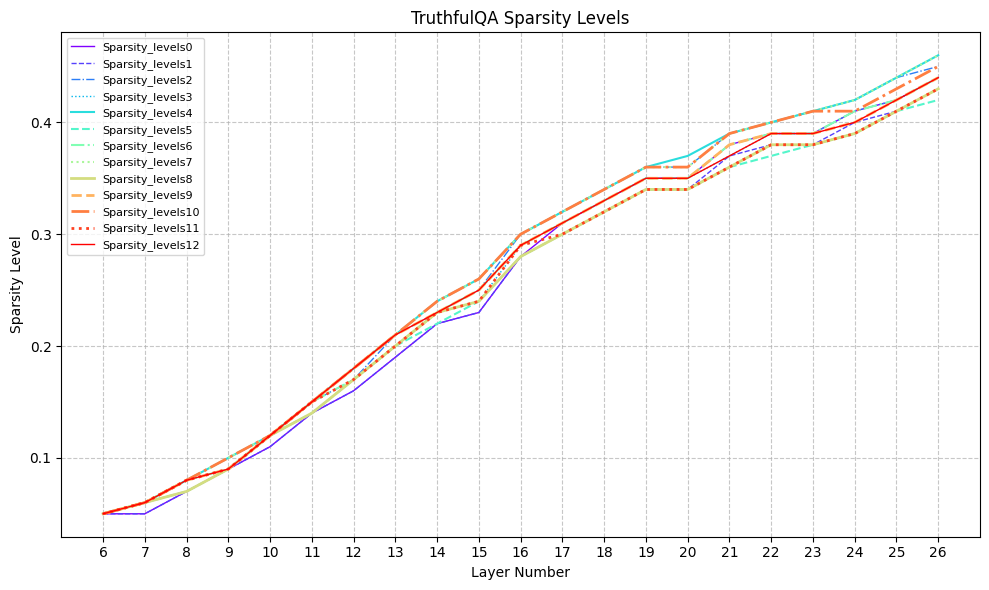

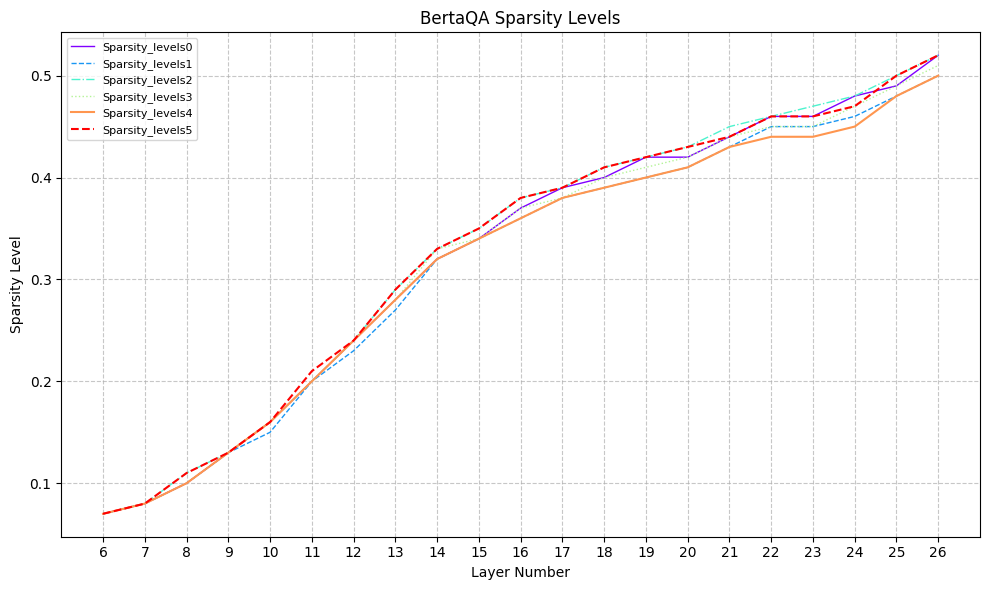

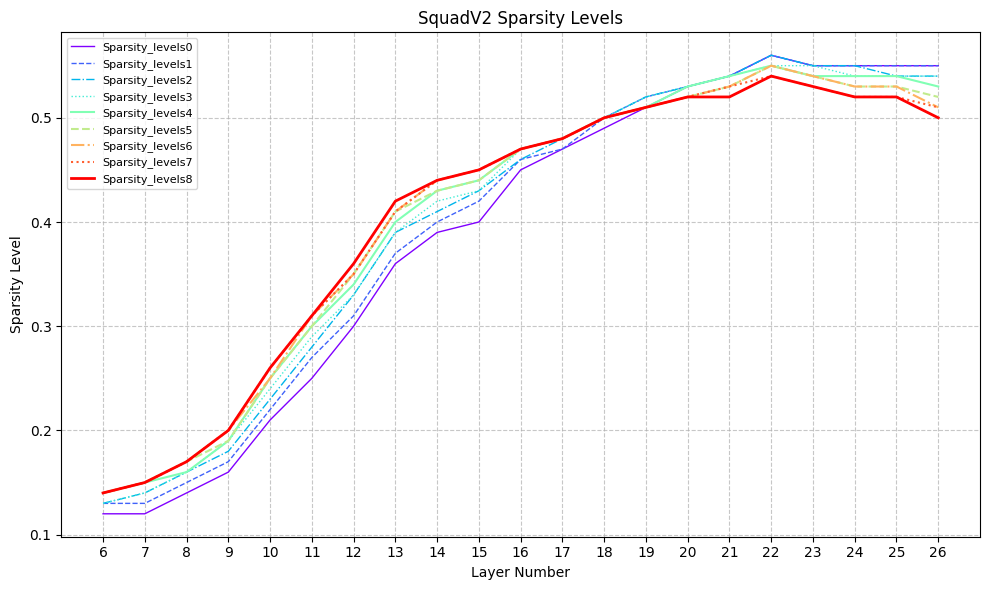

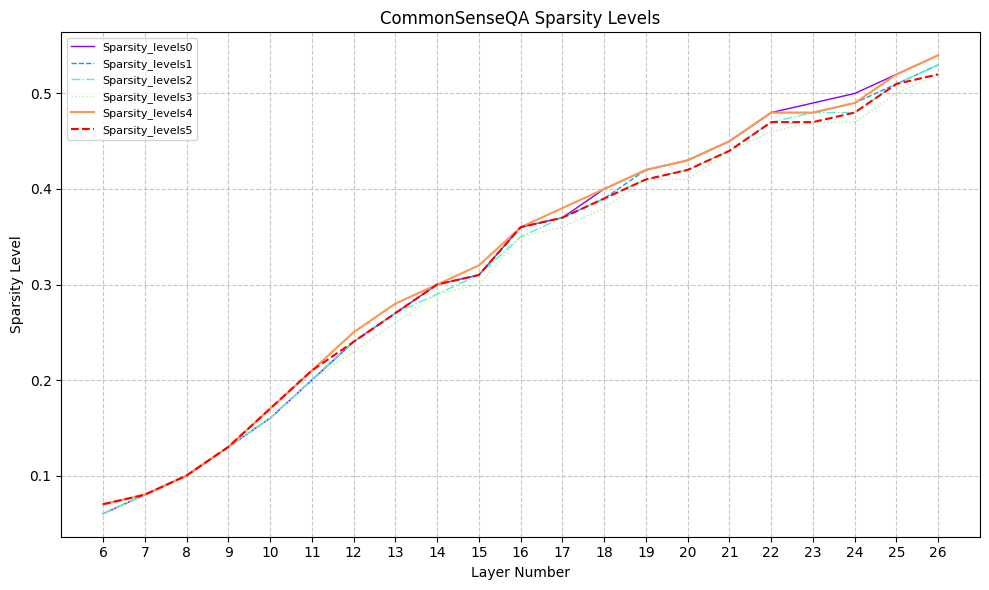

In [69]:
draw_levels(truthful_qa_sparsity_levels, "TruthfulQA")
draw_levels(berta_qa_sparsity_levels, "BertaQA")
draw_levels(squadv2_sparsity_levels, "SquadV2")
draw_levels(commonsense_qa_sparsity_levels, "CommonSenseQA")

## Actual Sparsity

In [2]:
import utils

output = utils.read_indecies_file("/local/huzaifa/CoreInfer/ignore/opt-6.7b_sparsity_levels_files/lm_eval_results[:100]/indices_all.txt", model_name, 5, 27)

results = {}
for o in output:
    task_name = o["task_name"]
    if task_name not in results:
        results[task_name] = []
        
    results[task_name].append({
        'sparsity_name': o['sparsity_name'],
        'avg': o['avg']
    })
    
for key,value in results.items():
    value.sort(key=lambda x: x['sparsity_name'])
    print(f"\nTask: {key}")
    for v in value:
        print(f"{v['sparsity_name']}: {v['avg']}")


Task: commonsense_qa
sparsity_levels0.pkl: 0.32069469633556547
sparsity_levels1.pkl: 0.3186862909226191
sparsity_levels2.pkl: 0.31560061500186004
sparsity_levels3.pkl: 0.3108693440755208
sparsity_levels4.pkl: 0.3220997546968005
sparsity_levels5.pkl: 0.3163329206194197

Task: bertaqa_en
sparsity_levels0.pkl: 0.3157909284319197
sparsity_levels1.pkl: 0.30980712890624995
sparsity_levels2.pkl: 0.3188968912760417
sparsity_levels3.pkl: 0.3140364583333335
sparsity_levels4.pkl: 0.30962265741257444
sparsity_levels5.pkl: 0.3182913062686012

Task: truthfulqa_gen
sparsity_levels0.pkl: 0.25433460053943446
sparsity_levels1.pkl: 0.24968677339099707
sparsity_levels10.pkl: 0.2615013195219494
sparsity_levels11.pkl: 0.2509589204334077
sparsity_levels12.pkl: 0.2560112072172619
sparsity_levels2.pkl: 0.26167117164248505
sparsity_levels3.pkl: 0.2559897867838543
sparsity_levels4.pkl: 0.26244896298363096
sparsity_levels5.pkl: 0.24921346028645844
sparsity_levels6.pkl: 0.25667739141555057
sparsity_levels7.pkl: 0